# Dynamic Bernstein–Vazirani
Modified from https://qiskit.org/ecosystem/mthree/tutorials/04_dynamic_bv.html

In [1]:
import numpy as np
from time import time
from qiskit import *
from qiskit.providers.fake_provider import FakeKolkata, FakeKolkataV2
import mthree
import matplotlib.pyplot as plt
#plt.style.use('quantum-light')

In [2]:
# Circuit generation function
def dynamic_bv(bitstring):
    """Create a Bernstein-Vazirani circuit from a given bitstring.

    Parameters:
        bitstring (str): A bitstring.

    Returns:
        QuantumCircuit: Output circuit.
    """
    qc = QuantumCircuit(2, len(bitstring))

    # Prepare the |-x> state on target qubit
    qc.x(1)
    qc.h(1)

    # For each bit (0 or 1) build a simple circuit block
    for idx, bit in enumerate(bitstring[::-1]):

        # Initial H gate on control
        qc.h(0)
        # If bit=1, do a CNOT gate
        if int(bit):
            qc.cx(0, 1)
        # Final H gate to convert phase to computational-basis
        qc.h(0)
        # Measure
        qc.measure(0, idx)

        # If not at the final bit, recycle and reset qubits
        if idx != (len(bitstring)-1):
            # Reset control qubit for reuse
            qc.reset(0)
            # reset target qubit to minimize dephasing
            qc.reset(1)
            # Prepare the |-x> state on target qubit again
            qc.x(1)
            qc.h(1)

    return qc

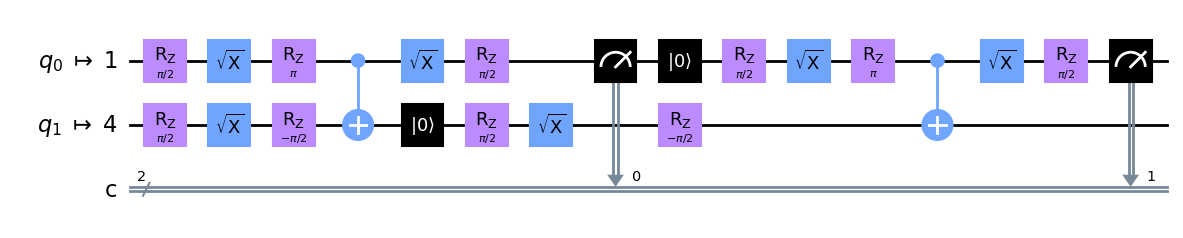

In [3]:
# Experiment setup
backend = FakeKolkata()
bit_range = range(2, 15)

circs = [dynamic_bv('1'*N) for N in bit_range]
trans_circs = transpile(circs, backend, optimization_level=3)
trans_circs[0].draw('mpl', idle_wires=False)

In [4]:
# run experiment with 10000 shots
shots = int(1e4)
counts = backend.run(trans_circs, shots=shots).result().get_counts()
#print (counts)

There is a bug in the M3 code that was hacked to make it work.

In [11]:
# M3
mit = mthree.M3Mitigation(backend)

# This gives error
#mappings = mthree.utils.final_measurement_mapping(trans_circs)

# A hack ti make M3 work
mappings = []
for idx, num_bits in enumerate(bit_range) :
    m = {i : 1 for i in range(num_bits)}
    mappings.append(m)

start       = time()
mit.cals_from_system(mappings)
end       = time()
print(f'M3 calibration time (ms): {(end - start)*1000:.2f}')

# Show a few of the mappings
#print (mappings[:3])
start       = time()
quasis = mit.apply_correction(counts, mappings)
end       = time()

print(f'M3 mitigation correction time (ms): {(end - start)*1000:.2f}')

M3 calibration time (ms): 77174.32
M3 mitigation correction time (ms): 94.01


In [12]:
# image filter mitogation
import mitigation as mitigation

start       = time()
in_range =  (0.02, 0.98) 
counts1 = mitigation.get_counts(counts, shots, in_range = in_range)
end       = time()

print(f'Filter mitigation at 2% execution time (ms): {(end - start)*1000:.2f}')

Filter mitigation at 2% execution time (ms): 10.00


In [13]:
count_probs = [counts[idx].get('1'*num_bits)/shots for idx, num_bits in enumerate(bit_range)]

# M3
quasi_probs = [quasis[idx].get('1'*num_bits) for idx, num_bits in enumerate(bit_range)]

# image filter
quasi_probs1 = [counts1[idx].get('1'*num_bits)/shots for idx, num_bits in enumerate(bit_range)]


Once again, after a simple modification of this test to include our technique, the result shows the intensity filter outperforming M3 as the number of qubits increases even at a low intensity level of 1%. Furthermore, by increasing this level the noise can be virtually eliminated. 

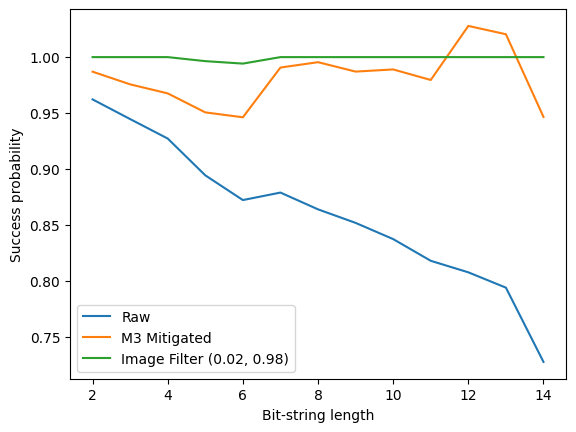

In [14]:
# plot
fig, ax = plt.subplots()
ax.plot(bit_range, count_probs, label='Raw')
ax.plot(bit_range, quasi_probs, label='M3 Mitigated')
ax.plot(bit_range, quasi_probs1, label='Image Filter ' + str(in_range))

ax.set_ylabel('Success probability')
ax.set_xlabel('Bit-string length')
ax.legend();